# Big Data Project
  ### MinJae Song
  ### Stephen Acurso
  ### CIS 4567 - Big Data Analytics. Dr. Salehan

# Bike Rentals
## Project Objective: We will use a bike sharing dataset to predict hourly bike rentals through relevant information such as time, weather, season, casual rentals, registered rentals, etc. Through our predictions, we will also be able to extract the more impacting variables relative to rental count. With good predictions, we can examine customer demand trends to prepare and decrease/increase supply.
## Method of Analysis: In order to predict future rentals, we will be using linear regression to create our model. Through iterations of linear regression we will choose the best model for our predictions and important features. However, if there is a need for improvement, we will try decision tree regression to improve our model. We will compare evaluation metrics on both methods and choose accordingly.
## Data description: Our dataset is from the UCI Data Repository for bike rentals. Our columns consist of variables such as: date, season (1:spring, 2:summer, 3:fall, 4:winter), year, month, hour, holiday (whether it is a holiday or not), day of the week, workingday (1:neither weekend nor holiday, 0:otherwise), weather status (1:clear, few clouds, partly cloudy, 2:mist,cloudy,mist+broken clouds,mist+fewclouds, 3:light snow, light rain+thunderstorm+scattered clouds, light rain+scattered clouds, 4:heavy rain+ice pallets+thunderstorm+mist, snow+fog), temperature, feels-like-temperature, humidity, wind speed, casual rentals, registered rentals, and total rentals.

In [1]:
import pyspark
sc.version

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
10,application_1575483558914_0011,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'2.4.4'

### import the dataset

In [2]:
import pyspark.sql.functions as func

bike_rental_path = 's3://2019fallcis4567/Big Data Project/hour.csv'

bike_rental = spark.read.csv(
    bike_rental_path
    , header=True
    , inferSchema=True
)

#remove leading or trailing spaces from text values
for col, typ in bike_rental.dtypes:
    if typ == 'string':
        bike_rental = bike_rental.withColumn(
            col
            , func.ltrim(func.rtrim(bike_rental[col]))
        )
bike_rental.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

17379

### dataset contains 17379 rows and 17 columns

In [3]:
bike_rental.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|instant|             dteday|season| yr|mnth| hr|holiday|weekday|workingday|weathersit|temp| atemp| hum|windspeed|casual|registered|cnt|
+-------+-------------------+------+---+----+---+-------+-------+----------+----------+----+------+----+---------+------+----------+---+
|      1|2011-01-01 00:00:00|     1|  0|   1|  0|      0|      6|         0|         1|0.24|0.2879|0.81|      0.0|     3|        13| 16|
|      2|2011-01-01 00:00:00|     1|  0|   1|  1|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0|     8|        32| 40|
|      3|2011-01-01 00:00:00|     1|  0|   1|  2|      0|      6|         0|         1|0.22|0.2727| 0.8|      0.0|     5|        27| 32|
|      4|2011-01-01 00:00:00|     1|  0|   1|  3|      0|      6|         0|         1|0.24|0.2879|0.75|      0.0|     3|        10| 13|
|      5|2011-01-01 00:00:00|     1|  0| 

# Checking for null values

In [4]:
bike_rental.rdd.map(
           lambda row: (
                 row['instant']
               , sum([c == None for c in row])
           )
        )\
        .filter(lambda el: el[1] >= 1)\
        .count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

There are no rows with missing values. We have a complete dataset, we can move forward.

In [5]:
bike_rental.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- instant: integer (nullable = true)
 |-- dteday: timestamp (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)

## we will get the count and compare with the distinct count to see if there are any duplicates in our rows

In [6]:
# do we have any rows that are duplicated?
bike_rental.count(), bike_rental.distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(17379, 17379)

### we don't have any duplicates or missing values in our dataset

# Checking dataset for outliers

In [7]:
features = ['season','mnth','hr','holiday','weekday','weathersit','temp','atemp','hum','windspeed', 'cnt']
quantiles = [0.25, 0.75]

cut_off_points = []

#getting Q1 and Q3
#The third parameter, set to 0.05, is relative target precision to achieve (>= 0).
#If set to zero, the exact quantiles are computed, which could be very expensive. 
for feature in features:
    quants = bike_rental.approxQuantile(feature, quantiles, 0.05)
    print(feature, quants)
    IQR = quants[1] - quants[0]
    cut_off_points.append((feature, [
        quants[0] - 1.5 * IQR,
        quants[1] + 1.5 * IQR,
    ]))

cut_off_points = dict(cut_off_points)

outliers = bike_rental.select(*['instant'] + [
       (
           (bike_rental[f] < cut_off_points[f][0]) |
           (bike_rental[f] > cut_off_points[f][1])
       ).alias(f + '_o') for f in features
  ])
outliers.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

season [2.0, 3.0]
mnth [4.0, 9.0]
hr [6.0, 17.0]
holiday [0.0, 0.0]
weekday [1.0, 5.0]
weathersit [1.0, 2.0]
temp [0.34, 0.64]
atemp [0.3333, 0.6061]
hum [0.48, 0.77]
windspeed [0.1045, 0.2537]
cnt [44.0, 255.0]
+-------+--------+------+-----+---------+---------+------------+------+-------+-----+-----------+-----+
|instant|season_o|mnth_o| hr_o|holiday_o|weekday_o|weathersit_o|temp_o|atemp_o|hum_o|windspeed_o|cnt_o|
+-------+--------+------+-----+---------+---------+------------+------+-------+-----+-----------+-----+
|      1|   false| false|false|    false|    false|       false| false|  false|false|      false|false|
|      2|   false| false|false|    false|    false|       false| false|  false|false|      false|false|
|      3|   false| false|false|    false|    false|       false| false|  false|false|      false|false|
|      4|   false| false|false|    false|    false|       false| false|  false|false|      false|false|
|      5|   false| false|false|    false|    false|       fa

In [8]:
#show the rows containing outliers
with_outliers_flag = bike_rental.join(outliers, on='instant')

(
    with_outliers_flag
    .filter('season_o OR mnth_o OR hr_o OR holiday_o OR weekday_o OR weathersit_o OR temp_o OR atemp_o OR hum_o OR windspeed_o OR cnt_o ')
    .select('season','mnth','hr','holiday','weekday','weathersit','temp','atemp','hum','windspeed', 'cnt')
    .show()
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+----+---+-------+-------+----------+----+------+----+---------+---+
|season|mnth| hr|holiday|weekday|weathersit|temp| atemp| hum|windspeed|cnt|
+------+----+---+-------+-------+----------+----+------+----+---------+---+
|     1|   1| 14|      0|      6|         1| 0.2|0.1667|0.32|   0.4925| 95|
|     1|   1| 17|      0|      6|         1|0.16|0.1212|0.37|   0.5522| 69|
|     1|   1|  9|      0|      0|         1|0.12|0.0758|0.46|   0.5224| 19|
|     1|   1| 11|      0|      0|         1|0.16|0.1212| 0.4|   0.5224| 49|
|     1|   1| 12|      0|      3|         1| 0.2|0.1515|0.47|   0.5821| 55|
|     1|   1| 18|      0|      3|         1| 0.2|0.1515|0.47|   0.5224|137|
|     1|   1|  0|      1|      1|         2| 0.2| 0.197|0.47|   0.2239| 17|
|     1|   1|  1|      1|      1|         2| 0.2| 0.197|0.44|    0.194| 16|
|     1|   1|  2|      1|      1|         2|0.18|0.1667|0.43|   0.2537|  8|
|     1|   1|  3|      1|      1|         2|0.18|0.1818|0.43|    0.194|  2|
|     1|   1

In [9]:
#We do have some outliers

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## we didnt get rid of any outliers because we want to observe our accuracy on the entire dataset and we want to improve our model after capturing the entire dataset

In [10]:
#describe numeric features
features = ['cnt', 'temp', 'atemp', 'hum', 'windspeed']
descriptive_stats = bike_rental.describe(features)
descriptive_stats.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+-------------------+------------------+-------------------+-------------------+
|summary|               cnt|               temp|             atemp|                hum|          windspeed|
+-------+------------------+-------------------+------------------+-------------------+-------------------+
|  count|             17379|              17379|             17379|              17379|              17379|
|   mean|189.46308763450142| 0.4969871684216586|0.4757751021347581| 0.6272288394038822| 0.1900976063064631|
| stddev| 181.3875990918646|0.19255612124972202|0.1718502156353594|0.19292983406291458|0.12234022857279034|
|    min|                 1|               0.02|               0.0|                0.0|                0.0|
|    max|               977|                1.0|               1.0|                1.0|             0.8507|
+-------+------------------+-------------------+------------------+-------------------+-------------------+

# You can see that temp, atemp, hum, and windspeed are all normalized which should assist in developing our model

In [11]:
#describe all columns
descriptive_stats_all = bike_rental.describe()
descriptive_stats_all.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+------------------+------------------+------------------+------------------+--------------------+-----------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-----------------+------------------+------------------+
|summary|          instant|            season|                yr|              mnth|                hr|             holiday|          weekday|        workingday|        weathersit|               temp|             atemp|                hum|          windspeed|           casual|        registered|               cnt|
+-------+-----------------+------------------+------------------+------------------+------------------+--------------------+-----------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+-----------------+------------------+------------------+
|  count|            17379|             17379|      

## after observing our data, we saw that our values for our numeric variables were already normalized, therefore we don't need it to normalize for our regression model. We may need to go back and use the index to get the original values if we plan to use a different method.

In [12]:
import pyspark.mllib.stat as st
import numpy as np

independent_variables = ['season','mnth','hr','workingday','weathersit','temp','atemp','hum','windspeed']
dependent_variable = ['cnt']
bike_sharing_df = bike_rental.select(independent_variables + dependent_variable)
for i in bike_sharing_df.columns:
    print("Correlation to CNT for ", i, bike_rental.stat.corr('cnt', i))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Correlation to CNT for  season 0.17805573098267663
Correlation to CNT for  mnth 0.12063776021315141
Correlation to CNT for  hr 0.3940714977829419
Correlation to CNT for  workingday 0.030284367747910726
Correlation to CNT for  weathersit -0.14242613813809568
Correlation to CNT for  temp 0.4047722757786578
Correlation to CNT for  atemp 0.40092930412663574
Correlation to CNT for  hum -0.32291074082456017
Correlation to CNT for  windspeed 0.09323378392612537
Correlation to CNT for  cnt 1.0

# Histogram for temperature and count.

In [13]:
#generate bins and count of each bin
histogram_temp = (
    bike_sharing_df
    .select('temp')
    .rdd
    .flatMap(lambda record: record)
    .histogram(5)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
#.histogram() generates two arrays: 
#1) list of bin bounds, 
#2) count of elements in corresponding bin
for i in histogram_temp:
    print(i)
    
histogram_temp

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.02, 0.216, 0.41200000000000003, 0.6080000000000001, 0.804, 1.0]
[1070, 5357, 5117, 5126, 709]
([0.02, 0.216, 0.41200000000000003, 0.6080000000000001, 0.804, 1.0], [1070, 5357, 5117, 5126, 709])

In [15]:
#display bin ranges
for i in range(len(histogram_temp[0])-1):
    print('[' + str(round(histogram_temp[0][i],2))
        + ',' + str(round(histogram_temp[0][i+1],2))
          + ')'
         )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.02,0.22)
[0.22,0.41)
[0.41,0.61)
[0.61,0.8)
[0.8,1.0)

In [16]:
#symbol * unpacks histogram_MPG and passes the two compoonents to zip as parameters
#zip(*histogram_MPG) = zip(histogram_MPG[0], histogram_MPG[1])
sorted(zip(*histogram_temp))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(0.02, 1070), (0.216, 5357), (0.41200000000000003, 5117), (0.6080000000000001, 5126), (0.804, 709)]

In [17]:
%%spark -o hist_temp 
#The above Spark magic exports hist_MPG to local node running the notebook
#So that we can use the local object to draw a histogram
import pandas as pd
hist_temp =  spark.createDataFrame(
    list(zip(*histogram_temp)), 
    ['bins', 'counts'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

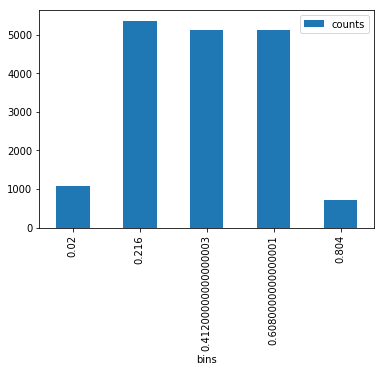

In [18]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
hist_temp.set_index('bins'
            ).plot(kind='bar')
plt.show()

## as expected, we see that there are far fewer rentals in temperatures that were low or high (compared to other values because the temperatures were normalized in the dataset. (change bin labels to easier names?) 

# Histogram for count and weather situation

In [19]:
#generate bins and count of each bin
histogram_weathersit = (
    bike_sharing_df
    .select('weathersit')
    .rdd
    .flatMap(lambda record: record)
    .histogram(4)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
for i in histogram_weathersit:
    print(i)
    
histogram_weathersit

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[1.0, 1.75, 2.5, 3.25, 4]
[11413, 4544, 1419, 3]
([1.0, 1.75, 2.5, 3.25, 4], [11413, 4544, 1419, 3])

In [21]:
#display bin ranges
for i in range(len(histogram_weathersit[0])-1):
    print('[' + str(round(histogram_weathersit[0][i],2))
        + ',' + str(round(histogram_weathersit[0][i+1],2))
          + ')'
         )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[1.0,1.75)
[1.75,2.5)
[2.5,3.25)
[3.25,4)

In [22]:
#symbol * unpacks histogram_MPG and passes the two compoonents to zip as parameters
#zip(*histogram_MPG) = zip(histogram_MPG[0], histogram_MPG[1])
sorted(zip(*histogram_weathersit))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(1.0, 11413), (1.75, 4544), (2.5, 1419), (3.25, 3)]

In [23]:
%%spark -o hist_weathersit 
#The above Spark magic exports hist_MPG to local node running the notebook
#So that we can use the local object to draw a histogram
import pandas as pd
hist_weathersit =  spark.createDataFrame(
    list(zip(*histogram_weathersit)), 
    ['bins', 'counts'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

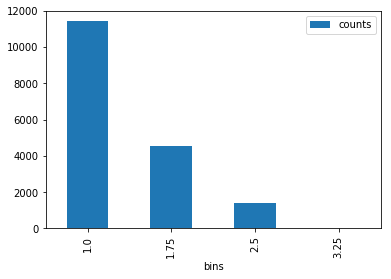

In [24]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
hist_weathersit.set_index('bins'
            ).plot(kind='bar')
plt.show()

# histogram on count and humidity

In [25]:
#generate bins and count of each bin
histogram_hum = (
    bike_sharing_df
    .select('hum')
    .rdd
    .flatMap(lambda record: record)
    .histogram(4)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
for i in histogram_hum:
    print(i)
    
histogram_weathersit

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.0, 0.25, 0.5, 0.75, 1.0]
[250, 4646, 7066, 5417]
([1.0, 1.75, 2.5, 3.25, 4], [11413, 4544, 1419, 3])

In [27]:
#display bin ranges
for i in range(len(histogram_hum[0])-1):
    print('[' + str(round(histogram_hum[0][i],2))
        + ',' + str(round(histogram_hum[0][i+1],2))
          + ')'
         )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[0.0,0.25)
[0.25,0.5)
[0.5,0.75)
[0.75,1.0)

In [28]:
#symbol * unpacks histogram_MPG and passes the two compoonents to zip as parameters
#zip(*histogram_MPG) = zip(histogram_MPG[0], histogram_MPG[1])
sorted(zip(*histogram_hum))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(0.0, 250), (0.25, 4646), (0.5, 7066), (0.75, 5417)]

In [29]:
%%spark -o hist_hum 
#The above Spark magic exports hist_MPG to local node running the notebook
#So that we can use the local object to draw a histogram
import pandas as pd
hist_hum =  spark.createDataFrame(
    list(zip(*histogram_hum)), 
    ['bins', 'counts'])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

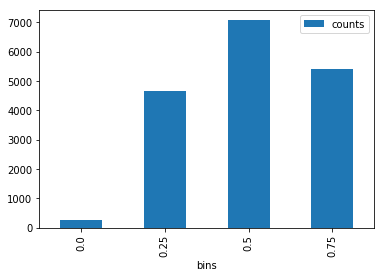

In [30]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
hist_hum.set_index('bins'
            ).plot(kind='bar')
plt.show()

## this histogram shows that users are renting more bikes when the humidity is considered normal, however we don't see a strong, obvious relationship

# Scatter plot for hour and count

In [31]:
%%spark -o scatter
#spark magic moves dataframe to local
scatter = (
    bike_rental
    .select('hr', 'cnt')
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
%%local
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.io import output_notebook
output_notebook()
p = figure(title = 'Relationship between rental count and hour')
p.xaxis.axis_label = 'Hour'
p.yaxis.axis_label = 'Rental Count'

p.circle(  list(scatter['hr'])
         , list(scatter['cnt'])
         , fill_alpha=0.2, size=10)

show(p)

Loading BokehJS ...

## We can observe how there are two distinguishable peaks in the scatter plot. these two peaks are at around the 7-8th hour and 15-17th hour of the day. This represents that the rental count is high when people commute to/from home (rush hour).

# Scatter plot for count and feels-like temperature

In [33]:
%%spark -o scatter2
#spark magic moves dataframe to local
scatter2 = (
    bike_rental
    .select('atemp', 'cnt')
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
%%local
from bokeh.io import show
from bokeh.plotting import figure
from bokeh.io import output_notebook
output_notebook()
p1 = figure(title = 'Relationship between rentals and feels-like temp')
p1.xaxis.axis_label = 'Rentals'
p1.yaxis.axis_label = 'Feels-like temperature'

p1.circle( list(scatter2['cnt'])
         , list(scatter2['atemp'])
         , fill_alpha=0.1, size=10)

show(p1)

Loading BokehJS ...

## this scatter plot shows that are a good number of rentals in high feels-like temperatures, but not many in the low temps. however, while there are more in the rentals in the high temps compared to the low temps, the mid-low temperatures seem to be when most rentals take place.

### we calculated the correlation to our dependent variable "count" and the other independent variables.
### from this we saw that hour, temp, feels-like temp, and humidity had the highest correlation to count
### some other variables such as mnth and season don't seem to have much correlation, possibly because our dataset are hourly records, so there is more correlation with the hour. as temp, and feels-like temp have similar values and correlation, we may want to drop temp as it can be redundant, and atemp (feels-like temp) is a better measure for our analysis.

In [35]:
import pyspark.mllib.stat as st
import numpy as np

independent_variables = ['season', 'yr', 'mnth','hr','holiday','weekday','workingday','weathersit','temp','atemp','hum','windspeed']
dependent_variable = ['cnt']
bike_sharing_df = bike_rental.select(independent_variables + dependent_variable)
for i in bike_sharing_df.columns:
    print("Correlation to CNT for ", i, bike_rental.stat.corr('cnt', i))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Correlation to CNT for  season 0.17805573098267663
Correlation to CNT for  yr 0.2504948988596486
Correlation to CNT for  mnth 0.12063776021315141
Correlation to CNT for  hr 0.3940714977829419
Correlation to CNT for  holiday -0.0309273032491106
Correlation to CNT for  weekday 0.026899859990839544
Correlation to CNT for  workingday 0.030284367747910726
Correlation to CNT for  weathersit -0.14242613813809568
Correlation to CNT for  temp 0.4047722757786578
Correlation to CNT for  atemp 0.40092930412663574
Correlation to CNT for  hum -0.32291074082456017
Correlation to CNT for  windspeed 0.09323378392612537
Correlation to CNT for  cnt 1.0

### these were the variables that we want to include into our model
### we didnt need some variables such as yr, season as the year doesn't matter to us and season can be told because we are including the month.
### we also decided to take out holiday and weekday because it can be interpreted as a variable we already have, "workingday". this is because we want to know if the day interpreted is a workingday or weekend, and if it is a workingday or holiday. also, we don't really need temp because atemp explains temp in a better perspective, and the correlations are similar as well as the records. we will only include atemp because feels-like temperature is a better measure.

In [36]:
cols_to_keep = bike_rental.dtypes

cols_to_keep = (
    ['cnt'                  #keep these columns
     ,'atemp','hum'
     ,'windspeed'
     ,'mnth','hr'
     ,'workingday'
     ,'weathersit'
        
    ]
    + [
        e[0] for e in cols_to_keep[:-1] #list comprehension
        if e[1] == 'string'             #keep String columns too
    ]
)

cols_to_keep

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['cnt', 'atemp', 'hum', 'windspeed', 'mnth', 'hr', 'workingday', 'weathersit']

### for some more descriptive statistics, we seperated the columns into numerical and categorical columns. we will be able to observe some of the stats and correlations between these variables

In [37]:
import pyspark.mllib.stat as st
import numpy as np

bike_rental_subset = bike_rental.select(cols_to_keep)

cols_num = (
    ['cnt','temp','atemp','hum','windspeed'
    
]
)
cols_cat = (
    ['mnth','hr'
     ,'workingday'
     ,'weathersit'    
]
)
cols_num, cols_cat

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(['cnt', 'temp', 'atemp', 'hum', 'windspeed'], ['mnth', 'hr', 'workingday', 'weathersit'])

In [38]:
cols = bike_rental.columns
bike_rental.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- instant: integer (nullable = true)
 |-- dteday: timestamp (nullable = true)
 |-- season: integer (nullable = true)
 |-- yr: integer (nullable = true)
 |-- mnth: integer (nullable = true)
 |-- hr: integer (nullable = true)
 |-- holiday: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- workingday: integer (nullable = true)
 |-- weathersit: integer (nullable = true)
 |-- temp: double (nullable = true)
 |-- atemp: double (nullable = true)
 |-- hum: double (nullable = true)
 |-- windspeed: double (nullable = true)
 |-- casual: integer (nullable = true)
 |-- registered: integer (nullable = true)
 |-- cnt: integer (nullable = true)

In [39]:
rdd_num = (
    bike_rental
    .select(cols_num)
    .rdd
    #aftr you convert df to rdd, each row looks like this:
    #Row(age=39, capital-gain=2174, capital-loss=0, hours-per-week=40),
    .map(lambda row: [e for e in row])
    #Then we map it to get rid of the the dictionary format and get to the following format:
    #[39, 2174, 0, 40]
)
rdd_num.take(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[[16, 0.24, 0.2879, 0.81, 0.0], [40, 0.22, 0.2727, 0.8, 0.0], [32, 0.22, 0.2727, 0.8, 0.0], [13, 0.24, 0.2879, 0.75, 0.0], [1, 0.24, 0.2879, 0.75, 0.0]]

## stats of the numeric variables
### because of our normalized dataset, there is no much to observe for the temp, atemp, hum, windpseed

In [40]:
stats_num = st.Statistics.colStats(rdd_num)

for col, min_, mean_, max_, var_ in zip(
      cols_num
    , stats_num.min()
    , stats_num.mean()
    , stats_num.max()
    , stats_num.variance()
):
    print('{0}: min->{1:.1f}, mean->{2:.1f}, max->{3:.1f}, stdev->{4:.1f}'
          .format(col, min_, mean_, max_, np.sqrt(var_)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

cnt: min->1.0, mean->189.5, max->977.0, stdev->181.4
temp: min->0.0, mean->0.5, max->1.0, stdev->0.2
atemp: min->0.0, mean->0.5, max->1.0, stdev->0.2
hum: min->0.0, mean->0.6, max->1.0, stdev->0.2
windspeed: min->0.0, mean->0.2, max->0.9, stdev->0.1

In [41]:
rdd_cat = (
    bike_rental
    .select(cols_cat) # bring column label back in
    .rdd
    .map(lambda row: [e for e in row])
)

#Create an empty dictionary
results_cat = {}

for i, col in enumerate(cols_cat):
    results_cat[col] = (
        rdd_cat
        .groupBy(lambda row: row[i]) #group by distinct values in column i
        .map(lambda el: (el[0], len(el[1]))) #map to (category name, count)
        .collect()
    )
    
#print the results
for k in results_cat:
    print(
        k #column name, dictionary key
        , sorted( #sort by frequency of each category, descending
            results_cat[k] #print results
            , key=lambda el: el[1] #use frequency for sorting
            , reverse=True)
        , '\n')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

mnth [(5, 1488), (7, 1488), (12, 1483), (8, 1475), (3, 1473), (10, 1451), (6, 1440), (4, 1437), (9, 1437), (11, 1437), (1, 1429), (2, 1341)] 

hr [(16, 730), (17, 730), (13, 729), (14, 729), (15, 729), (12, 728), (18, 728), (19, 728), (20, 728), (21, 728), (22, 728), (23, 728), (7, 727), (8, 727), (9, 727), (10, 727), (11, 727), (0, 726), (6, 725), (1, 724), (5, 717), (2, 715), (3, 697), (4, 697)] 

workingday [(1, 11865), (0, 5514)] 

weathersit [(1, 11413), (2, 4544), (3, 1419), (4, 3)]

### from this analysis, we can observe the number of rentals in each respective category. we can see the summer months have more rentals, however, it was also odd to see more rentals in december than in august.
### additionally, most rentals occur when the weather situation allows for riding. Harsh weather conditions are descriped as a "4", and only 3 rentals occured during the two years of our data.

### these are the correlations between the cnt and the numeric variables. temp,atemp, and humidity have high correlations with cnt meaning these variables are strong predictors to the hourly count of rentals and should be included in our model

In [42]:
correlations = st.Statistics.corr(rdd_num)
print(cols_num)
print(correlations)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['cnt', 'temp', 'atemp', 'hum', 'windspeed']
[[ 1.          0.40477228  0.4009293  -0.32291074  0.09323378]
 [ 0.40477228  1.          0.98767214 -0.06988139 -0.02312526]
 [ 0.4009293   0.98767214  1.         -0.0519177  -0.06233604]
 [-0.32291074 -0.06988139 -0.0519177   1.         -0.2901049 ]
 [ 0.09323378 -0.02312526 -0.06233604 -0.2901049   1.        ]]

In [43]:
#print correlations in pairs
for i, el_i in enumerate(abs(correlations) > 0.05):
    print(cols_num[i])
    
    for j, el_j in enumerate(el_i):
        if el_j and j != i:
            print(
                '    '
                , cols_num[j]
                , correlations[i][j]
            )
            
    print()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

cnt
     temp 0.40477227577869096
     atemp 0.40092930412669814
     hum -0.3229107408245724
     windspeed 0.09323378392612278

temp
     cnt 0.40477227577869096
     atemp 0.9876721390399834
     hum -0.06988139105126243

atemp
     cnt 0.40092930412669814
     temp 0.9876721390399834
     hum -0.05191769599338927
     windspeed -0.06233604268701625

hum
     cnt -0.3229107408245724
     temp -0.06988139105126243
     atemp -0.05191769599338927
     windspeed -0.2901048950638113

windspeed
     cnt 0.09323378392612278
     atemp -0.06233604268701625
     hum -0.2901048950638113

### a pivot table to see the number of rentals in each month by corresponding weathers situations and another pivot table showing the number of rentals in each weekday and if it is a working day or not. from the second pivot table we see that there are a lot of rentals during the working weekdays, however, not many rentals in non-working weekdays. therefore, there may not be many rentals during the holidays.

In [44]:
#make a pivot table
#Group by mnth and then weathersituation 
#to count how many in each weather situation
bike_rental_cnt_weathersit = (
    bike_rental
    .groupby('mnth')
    .pivot('weathersit')
    .count()
)

bike_rental_cnt_workingday = (
    bike_rental
    .groupby('weekday')
    .pivot('workingday')
    .count()
)
bike_rental_cnt_weathersit.show()
bike_rental_cnt_workingday.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+----+---+---+----+
|mnth|   1|  2|  3|   4|
+----+----+---+---+----+
|  12| 828|525|130|null|
|   1| 890|428|108|   3|
|   6|1093|275| 72|null|
|   3| 903|441|129|null|
|   5| 944|401|143|null|
|   9| 879|414|144|null|
|   4| 923|372|142|null|
|   8|1086|302| 87|null|
|   7|1172|254| 62|null|
|  10| 875|412|164|null|
|  11| 958|378|101|null|
|   2| 862|342|137|null|
+----+----+---+---+----+

+-------+----+----+
|weekday|   0|   1|
+-------+----+----+
|      1| 357|2122|
|      6|2512|null|
|      3|  24|2451|
|      5|  48|2439|
|      4|  48|2423|
|      2|  23|2430|
|      0|2502|null|
+-------+----+----+

In [45]:
len_ftrs = []

for col in cols_cat:
    (
        len_ftrs
        .append(
            (col
             , bike_rental
                 .select(col)
                 .distinct()
                 .count()
            )
        )
    )
    
len_ftrs = dict(len_ftrs)
len_ftrs

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'mnth': 12, 'hr': 24, 'workingday': 2, 'weathersit': 4}

In [46]:
cols_to_keep

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['cnt', 'atemp', 'hum', 'windspeed', 'mnth', 'hr', 'workingday', 'weathersit']

# Feature Engineering
## Vector Assembler
### most of the variables we want to include in our model are numeric and can be interpreted as features
### VectorAssembler allows us to put all features into a single vector for a Machine Learning Algorithm. we create the vectorassembler and pass the features we want to analyze. with this we have our features (independent variables) and count (dependent variable) for machine learning

In [63]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer

vectorAssembler = VectorAssembler(inputCols = ['mnth', 'hr', 'workingday', 'weathersit' 
                                               ,'atemp', 'hum', 'windspeed'], outputCol = 'features')
bike_rental_df = vectorAssembler.transform(bike_rental)
bike_rental_df.take(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(instant=1, dteday=datetime.datetime(2011, 1, 1, 0, 0), season=1, yr=0, mnth=1, hr=0, holiday=0, weekday=6, workingday=0, weathersit=1, temp=0.24, atemp=0.2879, hum=0.81, windspeed=0.0, casual=3, registered=13, cnt=16, features=DenseVector([1.0, 0.0, 0.0, 1.0, 0.2879, 0.81, 0.0]))]

In [64]:
bike_rental_df = bike_rental_df.select(['features', 'cnt'])
bike_rental_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---+
|            features|cnt|
+--------------------+---+
|[1.0,0.0,0.0,1.0,...| 16|
|[1.0,1.0,0.0,1.0,...| 40|
|[1.0,2.0,0.0,1.0,...| 32|
|[1.0,3.0,0.0,1.0,...| 13|
|[1.0,4.0,0.0,1.0,...|  1|
+--------------------+---+
only showing top 5 rows

### we used the 75%, 25% random split for our training/testing

In [65]:
splits = bike_rental_df.randomSplit([0.75, 0.25])
train = splits[0]
test = splits[1]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

# Linear Regression
### for our machine learning method, we implemented linear regression as it is a good regression model for prediction. it predicts a dependent variable based on the given independent variables, which is great for our model. Also, we believe that with our specific dataset and variables, linear regression can act as a good baseline model to improve on.

In [66]:
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'features', labelCol='cnt', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Coefficients: [4.878280003686827,7.3428522987873235,7.2119729111846125,-2.3345228327195064,345.980447744651,-224.27289878064633,26.684401585603922]
Intercept: 43.41736582286953

### after training the dataset with linear regression, we got a RMSE of 147.37 and a r2 score of 0.33.
### meaning that, our model explains 33% of the variability of the data around its mean
### it isn't the best, but we can still improve

In [67]:
lr_trainingSummary = lr_model.summary
print("RMSE: %f" % lr_trainingSummary.rootMeanSquaredError)
print("r2: %f" % lr_trainingSummary.r2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

RMSE: 148.993848
r2: 0.332598

In [68]:
train.describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+
|summary|              cnt|
+-------+-----------------+
|  count|            13003|
|   mean|191.0154579712374|
| stddev|182.3858620295932|
|    min|                1|
|    max|              977|
+-------+-----------------+

In [69]:
lr_predictions = lr_model.transform(test)
lr_predictions.select("prediction","cnt","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="cnt",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+---+--------------------+
|         prediction|cnt|            features|
+-------------------+---+--------------------+
| -67.76943066500706| 33|[1.0,0.0,0.0,1.0,...|
|-19.857031372117227| 28|[1.0,0.0,0.0,1.0,...|
| 36.514682823263044| 69|[1.0,0.0,0.0,1.0,...|
|  25.20037534330413| 39|[1.0,0.0,0.0,1.0,...|
| -18.68445377083094| 12|[1.0,0.0,1.0,1.0,...|
+-------------------+---+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.339685

In [70]:
test_result = lr_model.evaluate(test)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Root Mean Squared Error (RMSE) on test data = 144.893

### above are the RMSE and r2 score on the test data with linear regression

In [71]:
print("numIterations: %d" % lr_trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(lr_trainingSummary.objectiveHistory))
lr_trainingSummary.residuals.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

numIterations: 11
objectiveHistory: [0.5000000000000001, 0.4679200216261118, 0.335885732674642, 0.33533875893453013, 0.3350388018399574, 0.3350346261410569, 0.3350282680439472, 0.33502822136139065, 0.3350282172953921, 0.3350282172625244, 0.335028217262078]
+------------------+
|         residuals|
+------------------+
|50.708641208523346|
| 36.65196029961717|
| 74.86059140639139|
| 62.49224887998421|
|130.30016908500704|
|26.204657478999245|
|37.759374067393765|
|21.523310802215235|
|18.466525183074708|
|52.092154112801666|
|20.219561617119297|
| 19.00159659571591|
| -9.10135813787359|
|-71.13943726757397|
|  4.64887654507347|
|23.212851270959874|
| 5.520143392604766|
| 67.85190254288447|
|19.635603554110524|
|20.291948968811816|
+------------------+
only showing top 20 rows

### these are the predictions the linear model made

In [72]:
predictions = lr_model.transform(test)
predictions.select("prediction","cnt","features").show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+---+--------------------+
|         prediction|cnt|            features|
+-------------------+---+--------------------+
| -67.76943066500706| 33|[1.0,0.0,0.0,1.0,...|
|-19.857031372117227| 28|[1.0,0.0,0.0,1.0,...|
| 36.514682823263044| 69|[1.0,0.0,0.0,1.0,...|
|  25.20037534330413| 39|[1.0,0.0,0.0,1.0,...|
| -18.68445377083094| 12|[1.0,0.0,1.0,1.0,...|
| 13.721898414855797| 13|[1.0,0.0,1.0,1.0,...|
| 13.688662108969368| 11|[1.0,0.0,1.0,1.0,...|
| 29.794231303253653| 27|[1.0,0.0,1.0,2.0,...|
| -14.96981014180217| 25|[1.0,0.0,1.0,2.0,...|
|  40.71311240005706| 42|[1.0,0.0,1.0,2.0,...|
|   15.2452299267764| 38|[1.0,0.0,1.0,2.0,...|
| -39.57768848551933|  3|[1.0,0.0,1.0,3.0,...|
|  94.41478438197285| 73|[1.0,1.0,0.0,1.0,...|
|  83.33332347286229| 12|[1.0,1.0,0.0,1.0,...|
| 29.441763269355064| 93|[1.0,1.0,0.0,1.0,...|
| 0.7182169786740502| 42|[1.0,1.0,0.0,2.0,...|
|-49.352258125437544| 50|[1.0,1.0,0.0,2.0,...|
| 25.624299109723683| 16|[1.0,1.0,0.0,2.0,...|
| -2.86642136

# Decision Tree Regression
### to improve on our linear regression model, we implemented the decision tree regression method. Decision trees builds on regression in a tree structure, meaning that it breaks down the dataset into smaller subsets while it develops. Therefore, we implemented this model to try to improve

In [73]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'cnt')
dt_model = dt.fit(train)
dt_predictions = dt_model.transform(test)
dt_evaluator = RegressionEvaluator(
    labelCol="cnt", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
dt_evaluator1 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="cnt",metricName="r2")
dt_r2 = dt_evaluator1.evaluate(dt_predictions)
print("R Squared (R2) on test data = %g" % dt_r2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Root Mean Squared Error (RMSE) on test data = 113.093
R Squared (R2) on test data = 0.597719

### after implementing the model, we see improvement from the previous model
### on the test data, our model generated a RMSE of 115.22 and a r2 score of 0.61

In [74]:
train.take(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(features=DenseVector([1.0, 0.0, 0.0, 1.0, 0.0303, 0.45, 0.2537]), cnt=13)]

In [75]:
dt_model.featureImportances

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparseVector(7, {0: 0.0002, 1: 0.7631, 2: 0.0285, 3: 0.0111, 4: 0.1951, 5: 0.002})

### with our decision tree model, we want to see the features (independent variables) that impact "count" and their weight. in our observation we see that "hour" and "atemp" (feels-like temp) have the highest importance in regard to bike rentals

In [76]:
bike_rental_df.take(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(features=DenseVector([1.0, 0.0, 0.0, 1.0, 0.2879, 0.81, 0.0]), cnt=16)]

### in order to minimize our loss functions, we will also implement the Gradient-Boosted Trees (GBT) algorithm. we used this model instead of a random forest because GBT's train one tree at a time for a minimal loss function, and it also captures non-linearities and feature interactions.

In [77]:
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'cnt', maxIter=10)
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)
gbt_predictions.select('prediction', 'cnt', 'features').show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+---+--------------------+
|        prediction|cnt|            features|
+------------------+---+--------------------+
| 39.11398048841465| 33|[1.0,0.0,0.0,1.0,...|
| 39.38398788052057| 28|[1.0,0.0,0.0,1.0,...|
| 39.38398788052057| 69|[1.0,0.0,0.0,1.0,...|
| 39.38398788052057| 39|[1.0,0.0,0.0,1.0,...|
|27.185344292510926| 12|[1.0,0.0,1.0,1.0,...|
+------------------+---+--------------------+
only showing top 5 rows

In [78]:
gbt_evaluator = RegressionEvaluator(
    labelCol="cnt", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

gbt_evaluator1 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="cnt",metricName="r2")
gbt_r2 = gbt_evaluator1.evaluate(gbt_predictions)
print("R Squared (R2) on test data = %g" % gbt_r2)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Root Mean Squared Error (RMSE) on test data = 87.5606
R Squared (R2) on test data = 0.758859

### with the GBT, we were able to improve our model with a RMSE 86.74 and a r2 score of 0.77
### this means that our model explains 77% of the variability of the data around its mean.
### although we believe that our model could still improve and can act as a good baseline model. we observed that our models were making negative predictions when we can't have negative rental counts. also we can tune our parameters more to improve like possibly increasing the number of iterations or combining different base features. 
### additionally, we trained our model based on the dependent variable count, which is the total of registered rentals and casual rentals. however, registered cyclists and casual cyclists can rent for completely different reasons. For further observation, we can train two different models with registered/casual rentals being the dependent variable rather than the total count; with this two models we can add the both predictions to estimate our total count, and this could be a more accurate analysis
### with more variables, such as location or distance traveled, we can make more implications. however, with our dataset, we know that the time of the day is important for rentals as most rentals take place during 7-9am and 5-7pm. the feels-like temperature is also a factor that has impact on rentals.
### in the future, we can use different, recent datasets that have more variables to analyze and make more implications of.